# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

## Import libraries and file with settings

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import rasterstats as rstats
import xarray as xr
import rasterio as rio
import os, sys

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.1-beta
geopandas version: 0.7.0
xarray version: 0.15.1
rasterio version: 1.1.0
pandas version: 1.0.3
numpy version: 1.18.1
matplotlib version: 3.2.1
rasterstats version: 0.14.0


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [3]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [4]:
settings_file = r'../data/run_setting.cfg'

In [5]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file)

['../data/run_setting.cfg']

In [6]:
#out_dir
out_dir = config.get('general','output_dir')
if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
print('for the record, saving output to folder {}'.format(out_dir) + os.linesep)

for the record, saving output to folder C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT



# Applying functions

In [7]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe C:\Users\hoch0001\Documents\_code\conflict_model\data\UCDP/ged191.csv
...DONE

translating to geopandas dataframe
...DONE



In [8]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2005

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp
...DONE

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Functions

In [9]:
# def conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir, saving_plots=False, showing_plots=False):
#     """Determins per year the number of fatalities per country and derivates a boolean value whether conflict has occured in one year in one country or not.

#     Arguments:
#         conflict_gdf {geodataframe}: geodataframe containing final selection of georeferenced conflicts
#         extent_gdf {geodataframe}: geodataframe containing country polygons of selected extent
#         config {configuration}: parsed configuration settings

#     Keyword Arguments:
#         plotting {bool}: whether or not to make annual plots of boolean conflict and conflict fatalities (default: False)
#     """  
        
#     print('determining whether a conflict took place or not...')
    
#     # select the entries which occured in this year
#     temp_sel_year = conflict_gdf.loc[conflict_gdf.year == sim_year]
    
#     # merge this selection with the continent data
#     data_merged = gpd.sjoin(temp_sel_year, extent_gdf, how="inner", op='within')
    
#     # per country the annual total fatalities are computed and stored in a separate column
#     annual_fatalities_sum = pd.merge(extent_gdf,
#                                         data_merged['best'].groupby(data_merged['watprovID']).sum().\
#                                         to_frame().rename(columns={"best": "best_SUM"}),
#                                         on='watprovID')
    
#     print(data_merged['best'].groupby(data_merged['watprovID']).sum().\
#                                         to_frame().rename(columns={"best": "best_SUM"}))
    
#     # if the fatalities exceed 0.0, this entry is assigned a value 1, otherwise 0
#     annual_fatalities_sum['conflict_bool'] = np.where(annual_fatalities_sum['best_SUM']>0.0, 1, 0)

#     print('...DONE' + os.linesep)
        
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey=True)

#     annual_fatalities_sum.plot(ax=ax1,column='conflict_bool',
#                                     vmin=0,
#                                     vmax=2,
#                                     categorical=True,
#                                     legend=True)

#     temp_sel_year.plot(ax=ax1, legend=True, color='r', label='PRIO/UCDP events')

#     extent_gdf.boundary.plot(ax=ax1,
#                                 color='0.5',
#                                 linestyle=':',
#                                 label='water province borders')

#     ax1.set_xlim(extent_gdf.total_bounds[0]-1, extent_gdf.total_bounds[2]+1)
#     ax1.set_ylim(extent_gdf.total_bounds[1]-1, extent_gdf.total_bounds[3]+1)
#     ax1.set_title('conflict_bool ' + str(sim_year))

#     ax1.legend()
    
#     annual_fatalities_sum.plot(ax=ax2, 
#                                 column='best_SUM',
#                                 vmin=0,
#                                 vmax=1500,
#                                 legend=True,
#                                 legend_kwds={'label': "FATALITIES_SUM",
#                                             'orientation': "vertical"},)

#     extent_gdf.boundary.plot(ax=ax2,
#                                 color='0.5',
#                                 linestyle=':')

#     ax2.set_xlim(extent_gdf.total_bounds[0]-1, extent_gdf.total_bounds[2]+1)
#     ax2.set_ylim(extent_gdf.total_bounds[1]-1, extent_gdf.total_bounds[3]+1)
#     ax2.set_title('aggr. fatalities ' + str(sim_year))

#     fn_out = os.path.join(out_dir, 'boolean_conflict_map_' + str(sim_year) + '.png')
    
#     if saving_plots:
#         plt.savefig(fn_out, dpi=300)

#     if not showing_plots:
#         plt.close()

#     return temp_sel_year, data_merged, annual_fatalities_sum

In [56]:
def conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir):
    
    out_df = extent_gdf.copy()
    # each year initialize new column with default value 0 (=False)
    out_df['boolean_conflict_' + str(sim_year)] = 0
    out_df['sum_fatalities_' + str(sim_year)] = 0
    
    # select the entries which occured in this year
    temp_sel_year = conflict_gdf.loc[conflict_gdf.year == sim_year]   
    
    data_merged = gpd.sjoin(temp_sel_year, out_df)
    
    fatalities_per_watProv = data_merged['best'].groupby(data_merged['watprovID']).sum().to_frame().rename(columns={"best": 'bla'})
 
    for i in range(len(out_df)):
        i_watProv = out_df.iloc[i]['watprovID']
#         print('water province ID', i_watProv)
        if i_watProv in fatalities_per_watProv.index.values:
            fats = int(fatalities_per_watProv.loc[i_watProv])
#             print('fatalities in this water province in this year', fats)
            out_df.loc[i, 'boolean_conflict_' + str(sim_year)] = 1
            out_df.loc[i, 'sum_fatalities_' + str(sim_year)] = fats
        
    if not len(extent_gdf) == len(out_df):
        raise AssertionError('lengths do not match!')
    
    return out_df, data_merged, fatalities_per_watProv

# Analysis per year

In a first step, we want to know in which countries there was conflict or not. TO that end, we first accumulate the number of fatalities per country and use this as proxy whether there was a conlfict or not (guess there is a rather strong like...).

entering year 2000



No handles with labels found to put in legend.


entering year 2001



No handles with labels found to put in legend.


entering year 2002



No handles with labels found to put in legend.


entering year 2003



No handles with labels found to put in legend.


entering year 2004



No handles with labels found to put in legend.


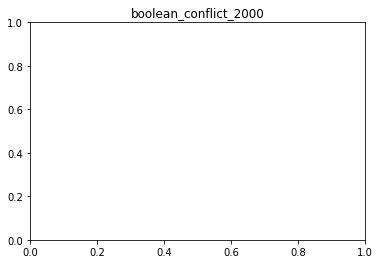

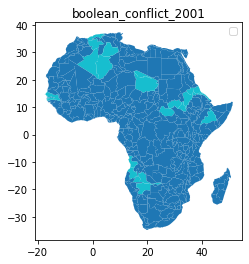

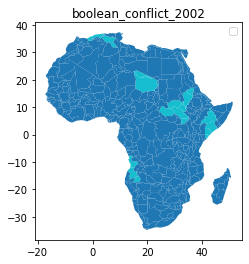

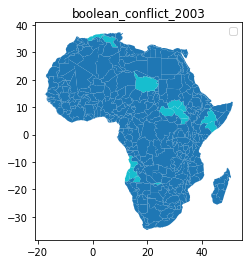

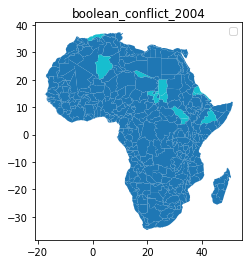

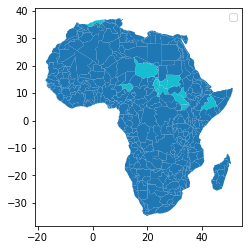

In [57]:
for sim_year in np.arange(config.getint('settings', 'y_start'), config.getint('settings', 'y_end'), 1):

    print('entering year {}'.format(sim_year) + os.linesep)
    
    out_df, data_merged, fatalities_per_watProv = conflict_in_year_bool(conflict_gdf, extent_gdf, config, sim_year, out_dir)
    
    extent_gdf = out_df.copy()
    
    plt.title('boolean_conflict_' + str(sim_year))
    extent_gdf.plot(column='boolean_conflict_' + str(sim_year), legend=True, categorical=True)
    plt.legend()

In [42]:
out_df

,OBJECTID,MAJORBASIN,COUNTRY,REGION,watprov,watprovID,km2,Shape_Leng,Shape_Area,geometry,boolean_conflict_2000,sum_fatalities_2000,boolean_conflict_2001,sum_fatalities_2001,boolean_conflict_2002,sum_fatalities_2002,boolean_conflict_2003,sum_fatalities_2003,boolean_conflict_2004,sum_fatalities_2004
0,1,"Africa, East Central Coast",Kenya,Central,"Kenya_Central_Africa, East Central Coast",14,13931.5,6.205310,1.124336,"POLYGON ((37.08624 0.01902, 37.09658 0.00645, ...",0,0,0,0,0,0,0,0,0,0
1,2,"Africa, East Central Coast",Kenya,Coast,"Kenya_Coast_Africa, East Central Coast",15,83147.1,21.014126,6.563633,"POLYGON ((38.74745 -0.07424, 38.75166 -0.07536...",0,0,0,0,0,0,0,0,0,0
2,3,"Africa, East Central Coast",Kenya,Eastern,"Kenya_Eastern_Africa, East Central Coast",16,56877.7,12.888855,4.591821,"POLYGON ((38.72441 0.31250, 38.72500 0.30998, ...",0,0,0,0,0,0,0,0,0,0
3,4,"Africa, East Central Coast",Kenya,North-Eastern,"Kenya_North-Eastern_Africa, East Central Coast",17,31577.9,12.223232,2.548920,"POLYGON ((40.99752 -0.14167, 40.99914 -0.83857...",0,0,0,0,0,0,0,0,0,0
4,5,"Africa, East Central Coast",Kenya,Rift Valley,"Kenya_Rift Valley_Africa, East Central Coast",18,13989.7,6.744464,1.129869,"POLYGON ((36.87503 -1.40625, 36.87704 -1.40849...",0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,382,Zambezi,Zambia,Southern,Zambia_Southern_Zambezi,1593,86170.5,14.436143,7.256196,"POLYGON ((28.91844 -15.94277, 28.91465 -15.949...",0,0,0,0,0,0,0,0,0,0
382,383,Zambezi,Zambia,Western,Zambia_Western_Zambezi,1594,127957.0,17.702749,10.723453,"POLYGON ((25.58817 -14.54020, 25.58638 -14.545...",0,0,0,0,0,0,0,0,0,0
383,384,Zambezi,Zimbabwe,Manicaland,Zimbabwe_Manicaland_Zambezi,1595,8287.9,5.327288,0.702946,"POLYGON ((33.04971 -17.33522, 33.05250 -17.344...",0,0,0,0,0,0,0,0,0,0
384,385,Zambezi,Zimbabwe,Mashonaland West,Zimbabwe_Mashonaland West_Zambezi,1596,146628.0,20.334327,12.408379,"POLYGON ((30.42273 -15.62230, 30.42242 -15.858...",0,0,0,0,0,0,0,0,0,0


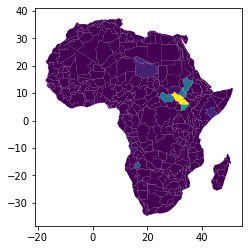

In [55]:
out_df.plot(column='sum_fatalities_2001')

In [ ]:
data_merged.head()

In [ ]:
len(data_merged)

In [ ]:
fatalities_per_watProv.index.values

In [ ]:
len(fatalities_per_watProv)

# Debugging

So the master dataframe with ALL conflicts reported looks like this...

In [ ]:
conflict_gdf.head()

...and has in total that many entries:

In [ ]:
len(conflict_gdf)

In the last year of the simulation period, a subset is created of all conflict entries which started in this year. It thus has the same columns as the master dataframe...

In [ ]:
temp_sel_year.head()

...but of course less entries, namely only that many entries:

In [ ]:
len(temp_sel_year)

This sub-set dataframe is then merged with the dataframe containing the geometry of the water provinces. Each conflict entry in the sub-set dataframe is assigned the water province (plus water province data) where the conflict took place.

In [ ]:
data_merged.head()

Logically, this merged dataframe has as many entries as the sub-set dataframe but more columns, i.e. those added from the extent dataframe:

In [ ]:
len(data_merged)

Per water province the number of fatalities is summed and added to a new column. Also, a boolean value of 1 (i.e. True) is assigned to each water province, indicating that one or more conflict took place in this province. The structure of the dataframe (besides the two added columns) is coming from the geometry/extent dataframe of the water provinces and NOT from the dataframe containing the conflict data.

In [ ]:
extent_waterProvinces_with_boolFatalities.head()

Since one or more conflicts can occur in one water province (which is very likely), only a few water provinces are found in this dataframe. This is also because the code currently drops all water provinces which have not seen conflict in this year.

In [ ]:
len(extent_waterProvinces_with_boolFatalities)

As a result, the zonal statistics are only stored for those water provinces.

NOTE: if you use the geometry/extent dataframe instead as argument, zonal statistics are computed for all water provinces, but then the columns containing (boolean) fatalities are lost.

In [ ]:
GDP_PPP_gdf.head()

In [ ]:
len(GDP_PPP_gdf)